In [3]:
# %load_ext autoreload
# %autoreload 2
from matplotlib.pyplot import colorbar
from PSNS_2D import *
from PSNS_Callbacks import CallbackVars,Callbacks,\
computeKE,vortexPairCenter,vortexPairRadius,\
areaIntegral,vortexPairCenterVortCentroid,vortexPairEulerResidue

from numpy import pi, cos, sin,exp
import pickle
from numpy import savetxt
import pandas as pd
from scipy.special import jv
import pickle
import matplotlib as mpl
import PSNS_2D

In [4]:
def window_fn(SV):
    X = SV.Mesh[0]
    Y = SV.Mesh[1]
    xl = SV.xR[0]
    xr = SV.xR[1]
    yl = SV.yR[0]
    yr = SV.yR[1]
    
    a = 1.05
    n = 27
    
    wx = 10**(-a**n*np.abs(2*(X-xl)/(xr-xl)-1)**n)
    wy = 10**(-a**n*np.abs(2*(Y-yl)/(yr-yl)-1)**n)
    w = wx*wy
    SV.U = SV.U*w
    
def initial_condition_LO_periodic(SV,N_ghost_x,N_ghost_y):
    X   = SV.Mesh
    xp  = X[0]
    yp  = X[1]
    sl  = SV.Lx
    a_sq = 0.05**2

    
#     Xc = [sl*0.5+0.5,sl*0.5-0.5]
#     Yc = [sl*0.5,sl*0.5]
#     Gam = [1,-1]
#     adding ghost vortex pairs in the x direction
#     for i in range(N_ghost_x):
#         Xc.extend([Xc[0]-sl*(i+1),Xc[1]-sl*(i+1),Xc[0]+sl*(i+1),Xc[1]+sl*(i+1)])
#         Yc.extend([Yc[0],Yc[1],Yc[0],Yc[1]])
#         Gam.extend([1,-1,1,-1])
    
#     for i in range(N_ghost_y):
#         Xc.extend([Xc[0],Xc[1],Xc[0],Xc[1]])
#         Yc.extend([Yc[0]-sl*(i+1),Yc[1]-sl*(i+1),Yc[0]+sl*(i+1),Yc[1]+sl*(i+1)])
#         Gam.extend([1,-1,1,-1])

    Xp = [sl*0.5+0.5,sl*0.5-0.5]
    Yp = [sl*0.5,sl*0.5]
    Xc = []
    Yc = []
    Gam = []
    for j in range(N_ghost_y):
        for i in range(N_ghost_x):
            if i==0 and j==0:
                Xc.extend([Xp[0],Xp[1]])
                Yc.extend([Yp[0],Yp[1]])
                Gam.extend([1,-1])
                            
            elif i==0:
                Xc.extend([Xp[0],Xp[1],Xp[0],Xp[1]])
                Yc.extend([Yp[0]-sl*(j),Yp[1]-sl*(j),Yp[0]+sl*(j),Yp[1]+sl*(j)])
                Gam.extend([1,-1,1,-1])
            elif j==0:
                Xc.extend([Xp[0]-sl*(i),Xp[1]-sl*(i),Xp[0]+sl*(i),Xp[1]+sl*(i)])
                Yc.extend([Yp[0],Yp[1],Yp[0],Yp[1]])
                Gam.extend([1,-1,1,-1])
            else:
                Xc.extend([Xp[0]-sl*(i),Xp[1]-sl*(i),Xp[0]+sl*(i),Xp[1]+sl*(i),\
                           Xp[0]-sl*(i),Xp[1]-sl*(i),Xp[0]+sl*(i),Xp[1]+sl*(i)])
                Yc.extend([Yp[0]-sl*(j),Yp[1]-sl*(j),Yp[0]+sl*(j),Yp[1]+sl*(j),\
                           Yp[0]+sl*(j),Yp[1]+sl*(j),Yp[0]-sl*(j),Yp[1]-sl*(j)])
                Gam.extend([1,-1,1,-1,1,-1,1,-1])
                
                
#             print(Xc,'\n',Yc)
#             print(len(Xc),len(Yc),len(Gam))

                
            
    

    # %matplotlib widget
    # fig, ax = plt.subplots()
    # ax.set_aspect('equal')
    # plt.scatter(Xc,Yc,c=Gam,s=3)
    # rec = mpl.patches.Rectangle([0,0],24,24,linestyle= '--',angle=0.0,fc ='none',ec ='r',lw = 1)
    # ax.add_patch(rec)
    # plt.xlabel('$x/b$')
    # plt.ylabel('$y/b$')
    # # plt.savefig("outputs/Sep11/plots/LO_init_vort_periodic.png", facecolor='none', bbox_inches="tight",\
    # #         pad_inches=0.05, transparent=True, dpi=300)
    # plt.show()
    
    def LO_vel(x_c,y_c,gam,xp,yp,a_sq):
        x  =  np.copy(xp) - x_c
        y  =  np.copy(yp) - y_c
        
        r_sq = np.square(x) + np.square(y) + 1e-16
        u = -gam*y*(1-exp(-r_sq/a_sq))/r_sq
        v =  gam*x*(1-exp(-r_sq/a_sq))/r_sq
        return u,v
    
    for xc,yc,gam in zip(Xc,Yc,Gam):
        u,v    = LO_vel(xc,yc,gam,xp,yp,a_sq)
        SV.U[0] += u
        SV.U[1] += v
#         %matplotlib inline
#         print('was here')
        
#         plt.show()
#     window_fn(SV)
    SV.U[1]  += (1-exp(-1/a_sq))
    
def initial_condition(SV):
    X = SV.Mesh
    sL = SV.Lx
    xc1 = 0.5
    xc2 = -0.5
    a_sq = 0.05**2
    x1    = (X[0]-0.5*sL - xc1)
    x2    = (X[0]-0.5*sL - xc2)
    
    y1    =  X[1] - 0.5*sL
    y2    =  X[1] - 0.5*sL
    r_sq1 = np.square(x1) + np.square(y1) + 1e-16
    r_sq2 = np.square(x2) + np.square(y2) + 1e-16
        


#     SV.U[0]  = -(y1*(1-exp(-r_sq1/a_sq))/r_sq1)
#     SV.U[1]  =  (x1*(1-exp(-r_sq1/a_sq))/r_sq1) 
    SV.U[0]  = -(y1*(1-exp(-r_sq1/a_sq))/r_sq1 - y2*(1-exp(-r_sq2/a_sq))/r_sq2)
    SV.U[1]  =  (x1*(1-exp(-r_sq1/a_sq))/r_sq1 - x2*(1-exp(-r_sq2/a_sq))/r_sq2) 
#     window_fn(SV)
    SV.U[1]  += (1-exp(-1/a_sq))
    

def initial_conditionScullyVP(SV):
    X = SV.Mesh
    sL = SV.Lx
    xc1 =  0.5
    xc2 = -0.5
    a_sq = 0.07**2
    x1    = (X[0]-0.5*sL - xc1)
    x2    = (X[0]-0.5*sL - xc2)
    y1    =  X[1] - 0.5*sL
    y2    =  X[1] - 0.5*sL
    r_sq1 = np.square(x1) + np.square(y1) 
    r_sq2 = np.square(x2) + np.square(y2) 

    SV.U[0]  = -(y1/(a_sq + r_sq1) - y2/(a_sq + r_sq2))
    SV.U[1]  =  (x1/(a_sq + r_sq1) - x2/(a_sq + r_sq2)) + 1/(1+a_sq)

def initial_conditionRankineVP(SV):
    X  = SV.Mesh
    sL = SV.Lx
    xc1 =  0.5
    xc2 = -0.5
    R_sq = 2*0.134**2
    x1    = (X[0]-0.5*sL - xc1)
    x2    = (X[0]-0.5*sL - xc2)
    y1    =  X[1] - 0.5*sL
    y2    =  X[1] - 0.5*sL
    r_sq1 = np.square(x1) + np.square(y1) + 1e-7
    r_sq2 = np.square(x2) + np.square(y2) + 1e-7


    SV.U[0] = -((y1/R_sq)*(r_sq1<=R_sq) +  (y1/r_sq1)*(r_sq1>R_sq)) + ((y2/R_sq)*(r_sq2<=R_sq) +  (y2/r_sq2)*(r_sq2>R_sq))   
    SV.U[1] =  ((x1/R_sq)*(r_sq1<=R_sq) +  (x1/r_sq1)*(r_sq1>R_sq)) - ((x2/R_sq)*(r_sq2<=R_sq) +  (x2/r_sq2)*(r_sq2>R_sq))
#     window_fn(SV)
    SV.U[1] += 1

def initial_condition_2DTGV(SV):
    X = SV.Mesh
    sL = SV.Lx
    SV.U[0] = 1.0 + 2.0*sin(2*pi*X[0]/sL)*cos(2*pi*X[1]/sL)
    SV.U[1] = 1.0 - 2.0*cos(2*pi*X[0]/sL)*sin(2*pi*X[1]/sL)

def LC_initial_condition(SV):
    U = 1
    R = 1
    mu_1 = 3.83170597020751
    
    X = SV.Mesh
    sL= SV.Lx
    # print(sL)
    x = X[0] - 0.5*sL
    y = X[1] - 0.5*sL
    r = np.sqrt(np.square(x)+np.square(y)) + 1e-6
    cos_theta = x/r
    A = 2*U*R/(mu_1*jv(0,mu_1))
    B = mu_1*r/R
    S = -A*jv(1,B)*cos_theta*(r<=R) - (r>R)*U*r*(1-(R/r)**2)*cos_theta 
    
    Sf = rfft2(S)
    # SV.U[0]  =   irfft2(1j*SV.K[1]*Sf)
    # SV.U[1]  =  -irfft2(1j*SV.K[0]*Sf) 
    
    SV.U[0]  =  np.gradient(S,SV.dy,axis=1)
    SV.U[1]  = -np.gradient(S,SV.dx,axis=0)
    
    # print(S.shape)
    return irfft2(Sf*SV.K_sq)

def vortex_pair_data_extractor(SV,filename):

    # only going to save the data for right vortex 
    # Nt = -1
    # Ut = SV.Ut[:,:,:,Nt]
    # Uf = rfft2(Ut)
    Xc,Xc_ind = vortexPairCenter(SV.Uf,SV)  # SV.Uf has the value for last time step
    xc = Xc[0,1]
    yc = Xc[1,1]
    xc_ind = Xc_ind[0,1]
    yc_ind = Xc_ind[1,1]

    xc_middle_plane = 0.5*(Xc[0,0]+Xc[0,1])
    padx = 2
    pady = 2

    # size of box center around the middle plane of the pair
    box_w = 2  # in length units 
    box_h = 4   # in length units
    box_w_ind = int(box_w/SV.dx)
    box_h_ind = int(box_h/SV.dy)

    x_ind1 = int(xc_ind - int(0.5*np.abs(Xc[0,0]-Xc[0,1])/SV.dx) - padx)
    x_ind2 = int(x_ind1 + box_w_ind   + padx)
    y_ind1 = int(yc_ind - box_h_ind/2 - pady)
    y_ind2 = int(yc_ind + box_h_ind/2 + pady)

    U = irfft2(SV.Uf)
    # xc_ind,yc_ind =int(CBV.vortex_pair_cent_ind[0,0,-1]),int(CBV.vortex_pair_cent_ind[1,0,-1])
    # vel = SV.U[1,xc_ind,yc_ind]

    U_extract    = np.copy(U[:,x_ind1:x_ind2,y_ind1:y_ind2])
    # U_extract[1] = U_extract[1] - vel

    Mesh_extract = np.copy(SV.Mesh[:,x_ind1:x_ind2,y_ind1:y_ind2])
    Mesh_extract[0] = Mesh_extract[0] - xc_middle_plane
    Mesh_extract[1] = Mesh_extract[1] - yc

    dudx, dudy, dvdx, dvdy = velGradient(SV.Uf,SV)
    dudx_e, dudy_e, dvdx_e, dvdy_e = dudx[x_ind1:x_ind2,y_ind1:y_ind2].flatten(), \
                                     dudy[x_ind1:x_ind2,y_ind1:y_ind2].flatten(), \
                                     dvdx[x_ind1:x_ind2,y_ind1:y_ind2].flatten(), \
                                     dvdy[x_ind1:x_ind2,y_ind1:y_ind2].flatten()

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    s_x = np.linspace(0,1,10)
    s_y = np.zeros(s_x.shape)
    start_points = np.array((s_x,s_y)).T
    print(start_points.shape)
    plt.streamplot(Mesh_extract[0].T,Mesh_extract[1].T, U_extract[0].T, U_extract[1].T,\
     density=[20,20],color='k',start_points=start_points,minlength=0.1)
    plt.contourf(Mesh_extract[0],Mesh_extract[1],U_extract[0],levels = 30)
    plt.colorbar()
    plt.show()

    x = Mesh_extract[0].flatten()
    y = Mesh_extract[1].flatten()
    u = U_extract[0].flatten()
    v = U_extract[1].flatten()

    df = pd.DataFrame({"x" : x, "y" : y,"u" : u, "v" : v,"dudx":dudx_e,"dudy":dudy_e,"dvdx":dvdx_e,"dvdy":dvdy_e})
    df.to_csv(filename, index=False)

def base_flow_constraint(SV):
    U = irfft2(SV.Uf*SV.dealias)
    SV.Wf = vorticity2D_f(SV.Uf,SV)
    Wx    = irfft2(1j*SV.K[0]*SV.Wf*SV.dealias) 
    Wy    = irfft2(1j*SV.K[1]*SV.Wf*SV.dealias) 

    residual = U[0]*Wx + U[1]*Wy
    
    # residual = Wy
    return residual


In [ ]:
# SV.Uf = rfft2(SV.U)

t1 = time.time()
# Re = 15708
Re = 3000
SV = SolverVars(xR =[0,20],yR = [0,20],nx=2048,ny=2048,dt=0.0005,T=5,anim_s=5,nu=2*pi/Re)
# SV = SolverVars(xR =[0,12],yR = [0,12],nx=512,ny=512,dt=0.001,T=0.8,anim_s=500,nu=2*pi/Re)
SV.a_targ=[0.1,0.15]
SV.padx = 180
SV.pady = 220
# SV.padx = 180
# SV.pady = 180

CBV = CallbackVars(SV)
generate_mesh(SV)
wavespace(SV)
# vort = LC_initial_condition(SV)
initial_condition(SV)
# initial_condition_LO_periodic(SV,10,10)

# initial_conditionRankineVP(SV)
# initial_conditionScullyVP(SV)
# initial_condition_2DTGV(SV)

solve_RK4(SV,CBV)

# for i in range(2): SV.Uf[i] = rfft2(SV.U[i])
print("Total simulation time == ",time.time()-t1)
plt.show()

Iteration ==  5 a_rad ==  0.0502093008525413
Iteration ==  10 a_rad ==  0.05041829081292163
Iteration ==  15 a_rad ==  0.05062674113971201
Iteration ==  20 a_rad ==  0.050834410188966464
Iteration ==  25 a_rad ==  0.051041082358901306
Iteration ==  30 a_rad ==  0.05124661424983806
Iteration ==  35 a_rad ==  0.051450951339925034
Iteration ==  40 a_rad ==  0.05165412014195022
Iteration ==  45 a_rad ==  0.05185620591369661
Iteration ==  50 a_rad ==  0.052057324978242975
Iteration ==  55 a_rad ==  0.052257598236027304


In [ ]:
filename = "outputs/Nov3/ext_data/velsp_rc_0.1_0.15_LO_st_nd_L24_2048_re_3000_per.csv"
vortex_pair_data_extractor(SV,filename)
res = base_flow_constraint(SV)
for i in range(2): SV.Uf[i] = rfft2(SV.U[i])
filename = r'outputs/Nov3/ouputs/Aug25/full_data/data_rc_0.1_0.15_LO_st_nd_L24_2048_re_3000_per.pkl'    
save(SV,CBV,res,filename)

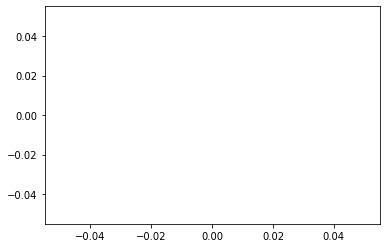

In [6]:
%matplotlib inline
plt.plot(SV.U[1,100,:])
plt.show()
# SV.U[1,512,:]

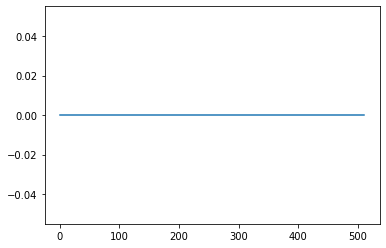

In [18]:
plt.plot(SV.U[0,100,:])
plt.show()

In [175]:
vortexPairEulerResidue(SV,CBV)

3.29311757761461
[[256 346]
 [211 301]]


In [5]:
filename = "outputs/Sep11/ext_data/velsp_rc_0.2_LO_st_nd_L24_2048_re_3000__periodic_init_a0_0_1.csv"
vortex_pair_data_extractor(SV,filename)
res = base_flow_constraint(SV)
for i in range(2): SV.Uf[i] = rfft2(SV.U[i])
filename = r'E:/OneDrive/Research/code/PsuedoSpecNS/outputs/Sep11/full_data/data_rc_0.2_LO_st_nd_L24_2048_re_3000_periodic_init_a0_0_1.pkl'    
save(SV,CBV,res,filename)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(10, 2)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
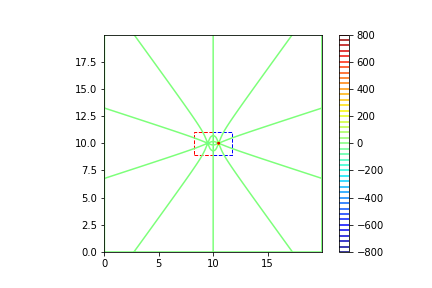

(-6.2831845279188165,
 9.50000008242319,
 10.000000000605745,
 0.03535426387773536,
 0.035353309484955575,
 0.04999780461055858,
 array([ 9.5, 10. ]),
 array([0., 0.]))

In [18]:
Nt = 0
Ut = SV.Ut[:,:,:,Nt]
Ut = np.copy(SV.U)


Uf = rfft2(Ut)
W = np.zeros((SV.nx,SV.ny),dtype=dtype_re)
W = vorticity2D(Uf,SV)
S = streamfunction(Uf,SV)
W_d = vorticity2D_fd(Ut,SV)
# W_df = rfft2(W_d)*sig
# W_d = irfft2(W_df)


%matplotlib widget
# %matplotlib inline
# Xc,XCind = vortexPairCenter(Uf,SV)
Xc,XCind = vortexPairCenterVortCentroid(Uf,SV)


SV.padx = 180
SV.pady = 220
padx = SV.padx
pady = SV.pady
x1 = int(0.5*SV.nx-padx)
x2 = int(0.5*SV.nx)
# x1 = int(0.5*SV.nx)
# x2 = int(0.5*SV.nx+padx)
y1 = int(XCind[1,1]-pady*0.5)
y2 = int(XCind[1,1]+pady*0.5)

shiftx = 0
fig, ax = plt.subplots()
ax.set_aspect('equal')
# plt.contour(W.T,levels = 50,cmap='jet')
# plt.contourf(SV.Mesh[0],SV.Mesh[1],Ut[1].T*0.05,levels = 100,cmap='jet')
# plt.contourf(SV.Mesh[0],SV.Mesh[1],W*0.05,levels = 100,cmap='jet')
plt.contour(SV.Mesh[0],SV.Mesh[1],W_d,levels = 50,cmap='jet')
# plt.contourf(S.T,levels = 50,cmap='jet')
# plt.contourf(vort.T,levels = 50,cmap='jet')


# plt.plot(Xc[0,0],Xc[1,0],'ro',markersize=2)
# plt.plot(Xc[0,1],Xc[1,1],'ro',markersize=2)

# plt.plot(XCind[0,0],XCind[1,0],'ro',markersize=2)
# plt.plot(XCind[0,1],XCind[1,1],'ro',markersize=2)
rec = mpl.patches.Rectangle([SV.Mesh[0,x1,y1],SV.Mesh[1,x1,y1]], SV.Mesh[0,x2,y2]-SV.Mesh[0,x1,y2], SV.Mesh[1,x2,y2]-SV.Mesh[1,x1,y1],linestyle= '--',angle=0.0,fc ='none',ec ='r',lw = 1)
rec2 = mpl.patches.Rectangle([SV.Mesh[0,x1+padx,y1],SV.Mesh[1,x1,y1]], SV.Mesh[0,x2,y2]-SV.Mesh[0,x1,y2], SV.Mesh[1,x2,y2]-SV.Mesh[1,x1,y1],linestyle='--', angle=0.0,fc ='none',ec ='b',lw = 1)
ax.add_patch(rec)
ax.add_patch(rec2)
plt.colorbar()
# plt.clim(-1.8,1.8)
plt.show()


W_test = W
Gamma = (W_test[x1:x2,y1:y2]).sum()*SV.dx*SV.dy
xc = np.sum( SV.Mesh[0,x1:x2,y1:y2]*W_test[x1:x2,y1:y2]*SV.dx*SV.dy)/Gamma
yc = np.sum( SV.Mesh[1,x1:x2,y1:y2]*W_test[x1:x2,y1:y2]*SV.dx*SV.dy)/Gamma
# xc = Xc[0,0]
# yc = Xc[1,0]
ax = np.sqrt(np.abs(np.sum((SV.Mesh[0,x1:x2,y1:y2]-xc)**2*W_test[x1:x2,y1:y2])*SV.dx*SV.dy/Gamma))
ay = np.sqrt(np.abs(np.sum((SV.Mesh[1,x1:x2,y1:y2]-yc)**2*W_test[x1:x2,y1:y2])*SV.dx*SV.dy/Gamma))


Gamma,xc,yc,ax,ay,(ax**2+ay**2)**0.5,Xc[:,0],CBV.vortex_pair_rad[:,0,-1]
# XCind


# XCind,Xc
# plt.savefig("ouputs/Aug25/plots/LO_init_vort_box.png", facecolor='none', bbox_inches="tight",
#             pad_inches=0.05, transparent=True, dpi=300)


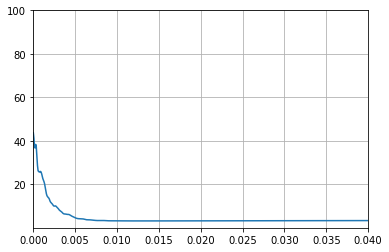

In [141]:
CBV_8 = CBV
SV_8 = SV
# CBV_12 = CBV
# SV_12  = SV

%matplotlib inline
XCind,Xc
t = np.arange(0,SV.T,SV.dt)*(1/0.067**2)/Re
N = 800
ax = CBV.vortex_pair_rad[0,1]
ay = CBV.vortex_pair_rad[1,1]
E = ay/ax

# plt.plot(t[:N],E[:N])
# plt.semilogy(t[:N],CBV_6_5.eulerResidual[1,:N])
# plt.semilogy(t[:N],CBV.eulerResidual[1,:N])
plt.plot(t[:N],CBV.eulerResidual[1,:N])
# plt.semilogy(t[:N],CBV_7.eulerResidual[1,:N])
# plt.plot(CBV_8.temp1[:])
# plt.plot(CBV_7.temp1[:])
# plt.plot(CBV_6_5.temp1[300:])
# plt.plot(CBV.temp1[300:])

plt.xlim([0,0.04])
plt.ylim([1e-3,1e2])
plt.grid()
plt.show()
# plt.plot(CBV.residual[1,:])
# CBV.eulerResidual.shape

In [197]:
# SV.Uf = rfft2(SV.U)
# file_out = open("ER.txt","a")

SV_i = SV

ER = np.zeros(51)
for i in range(51):
    Nt = i
    U  = SV_i.Ut[:,:,:,Nt]
    # U = np.copy(SV.U)
    Uf = rfft2(U)

    # Uf = 
    Xc,Xcind = vortexPairCenterVortCentroid(Uf,SV)

    Wf = vorticity2D_f(Uf,SV_i)
    W  = vorticity2D(Uf,SV_i)

    Wx_f  = 1j*Wf*SV_i.K[0]*SV_i.fou_filt
    Wy_f  = 1j*Wf*SV_i.K[1]*SV_i.fou_filt
    Wx    = irfft2(Wx_f)
    Wy    = irfft2(Wy_f)

    # for i in range(2): U[i,:,:] = irfft2(Uf[i])

    pady = SV_i.padx
    padx = SV_i.pady
    x1 = int(0.5*SV_i.nx-padx)
    x2 = int(0.5*SV_i.nx)
    y1 = int(Xcind[1,1]-pady*0.5)
    y2 = int(Xcind[1,1]+pady*0.5)

    # left vortex integrals
    Q = np.square(U[0]*Wx + U[1]*Wy)
    limits = np.array([[x1,x2],[y1,y2]])
    ER_numer = areaIntegral(Q,SV_i,limits)
    ER_denom = areaIntegral(np.square(W),SV_i,limits)
    ER[Nt] = (ER_numer/ER_denom)**0.5

# A = np.sum(np.square(SV_i.U[0,x1:x2,y1:y2]*Wx[x1:x2,y1:y2] + SV_i.U[1,x1:x2,y1:y2]*Wy[x1:x2,y1:y2]))*SV_i.dx*SV_i.dy
# B = np.sum(np.square(SV_i.W[x1:x2,y1:y2]))*SV_i.dx*SV_i.dy

(ER_numer/ER_denom)**0.5,CBV.eulerResidual[0,-1],ER_numer,ER_denom



(0.0728081377594133,
 0.07280812491768232,
 3.7190647598450863,
 701.5746602155576)

In [191]:
SV_i = SV
Nt = 10

# U  = SV_i.Ut[:,:,:,Nt]
# # U = np.copy(SV.U)
# Uf = rfft2(U)

# U = np.copy(SV.U[:,:,:])
Uf_i = np.copy(SV.Uf)
U = irfft2(SV.Uf)
Uf = rfft2(U)
# Uf = np.copy(SV.Uf)

# Uf = 
Xc,Xcind = vortexPairCenterVortCentroid(Uf,SV)

Wf = vorticity2D_f(Uf,SV)
W  = vorticity2D(Uf,SV)

SV.W  = PSNS_2D.vorticity2D(SV.Uf,SV)

Wx_f  = 1j*Wf*SV_i.K[0]*SV_i.fou_filt
Wy_f  = 1j*Wf*SV_i.K[1]*SV_i.fou_filt
Wx    = irfft2(Wx_f)
Wy    = irfft2(Wy_f)

# for i in range(2): U[i,:,:] = irfft2(Uf[i])

pady = SV_i.padx
padx = SV_i.pady
# x1 = int(0.5*SV_i.nx-padx)
# x2 = int(0.5*SV_i.nx)
x1 = int(0.5*SV.nx)
x2 = int(0.5*SV.nx+padx)
y1 = int(Xcind[1,1]-pady*0.5)
y2 = int(Xcind[1,1]+pady*0.5)

# left vortex integrals
Q = np.square(U[0]*Wx + U[1]*Wy)
limits = np.array([[x1,x2],[y1,y2]])
ER_numer = areaIntegral(Q,SV_i,limits)
ER_denom = areaIntegral(np.square(W),SV_i,limits)
(ER_numer/ER_denom)**0.5,ER_numer,CBV.eulerResidual[0,-1]



(0.027334398756749232, 0.5529564804157256, 0.027438263634627442)

In [150]:
Uf_latest = SV.Uf

In [189]:
%matplotlib widget
plt.contourf(Uf[0]-Uf_i[0])
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [169]:
# SV.Uf = rfft2(SV_i.Ut[:,:,:,20])
vortexPairEulerResidue(SV,CBV)

0.0728803243376761
[[256 346]
 [211 301]]


In [144]:
%matplotlib widget
q = (CBV.temp_ux*CBV.temp_wx+ CBV.temp_uy*CBV.temp_wy)
q2 = (CBV.temp_ux*Wx + CBV.temp_uy*Wy)
# q = (CBV.temp_ux*CBV.temp_wx) 
# q2 = (CBV.temp_ux*Wx)
# q = ( CBV.temp_uy*CBV.temp_wy)
# q2 = ( CBV.temp_uy*Wy)

plt.contourf(q.T)
# plt.contourf(q2.T)
# plt.contourf(CBV.temp_q.T)
# plt.contourf(CBV.temp_ux.T)
# plt.contourf(CBV.temp_uy.T)
# plt.contourf(CBV.temp_wx.T)
# plt.contourf(CBV.temp_wy.T)
# plt.contourf(CBV.temp_w.T)

# plt.contourf(W.T-CBV.temp_w.T)
# plt.contourf(U[0].T,levels=10)
# plt.contourf(U[0].T-CBV.temp_ux.T)
# plt.contourf(Wx.T-CBV.temp_wx.T)
# plt.contourf(Wx.T)
# plt.contourf((Q).T)
# plt.contourf(SV.W.T-W.T)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

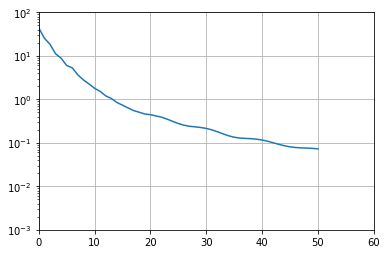

In [200]:
# t = np.arange(0,SV.T,SV.dt)*(1/0.067**2)/Re


plt.semilogy(ER)
plt.ylim([1e-3,1e2])
plt.xlim([0,60])
plt.grid()
plt.show()

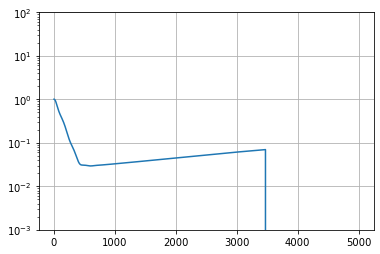

In [9]:
%matplotlib inline
# XCind,Xc
t = np.arange(0,SV.T,SV.dt)*(1/0.067**2)/Re
N = 4999
ax = CBV.vortex_pair_rad[0,1]
ay = CBV.vortex_pair_rad[1,1]
# E = ay/ax

# plt.plot(t[:N],E[:N])
plt.semilogy(CBV.eulerResidual[1,:N])
# plt.plot(CBV.temp2[:])
# plt.plot(CBV.temp1[:])
# plt.xlim([0,0.04])
plt.ylim([1e-3,1e2])
plt.grid()
plt.show()
# plt.plot(CBV.residual[1,:])
# CBV.eulerResidual.shape

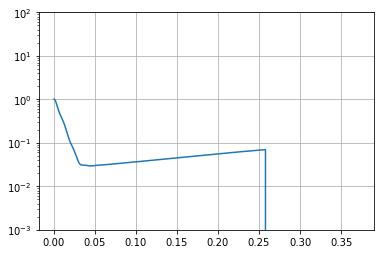

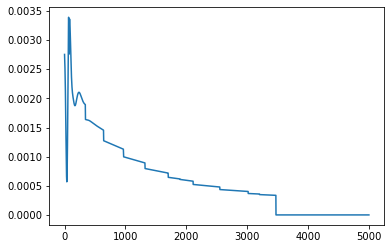

In [10]:
%matplotlib inline
# XCind,Xc
t = np.arange(0,SV.T,SV.dt)*(1/0.067**2)/Re
N = 4999
ax = CBV.vortex_pair_rad[0,1]
ay = CBV.vortex_pair_rad[1,1]
# E = ay/ax

# plt.plot(t[:N],E[:N])
plt.semilogy(t[:N],CBV.eulerResidual[1,:N])
# plt.plot(CBV.temp2[:])
# plt.plot(CBV.temp1[:])
# plt.xlim([0,0.04])
plt.ylim([1e-3,1e2])
plt.grid()
plt.show()
plt.plot(CBV.max_val_residual[1,1:])
# plt.plot(CBV.residual[1,:])

In [208]:
SV_1 = SV
CBV_1 = CBV

F:\Anaconda3\anaconda\envs\numcomp\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


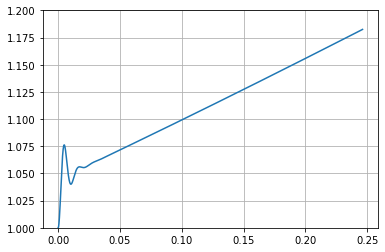

In [9]:
%matplotlib inline
# XCind,Xc
t = np.arange(0,SV.T,SV.dt)*(1/0.067**2)/3142
N = 4000
ax = CBV.vortex_pair_rad[0,1]
ay = CBV.vortex_pair_rad[1,1]
E = ay/ax
plt.plot(t[:N],E[:N])
# plt.semilogy(t[:N],CBV.eulerResidual[1,:N])
# plt.xlim([0,0.04])
plt.ylim([1,1.2])
# plt.ylim([1e-3,1e2])
plt.grid()
plt.show()
# plt.plot(CBV.residual[1,:])
# CBV.eulerResidual.shape

In [41]:
%matplotlib widget

# plt.plot(Ut[1,:,256])
# plt.plot(Ut[0,512,:])
# plt.hlines(0,0,1024,'r')
plt.plot(W[:,200])
# plt.plot(W_d[:,512])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [224]:
%matplotlib widget

plt.plot(Ut[1,:,512])
plt.hlines(1,0,1024,'r')
# plt.plot(W[:,512])
# plt.plot(W_d[:,512])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
%matplotlib inline
plt.plot(CBV.max_val_residual[0,1:])
plt.show()
plt.plot(CBV.max_val_residual[1,1:])
plt.show()

In [ ]:
%matplotlib inline
a = np.sqrt(CBV.vortex_pair_rad[0,0,1:]**2 + CBV.vortex_pair_rad[1,0,1:]**2)
E = CBV.vortex_pair_rad[1,0,1:]/CBV.vortex_pair_rad[0,0,1:]
# plt.plot(np.sqrt(CBV.vortex_pair_rad[0,0,:]**2 + CBV.vortex_pair_rad[1,0,:]**2))
plt.plot(E)
plt.show()

CBV.vortex_pair_rad[0,0,SV.it],CBV.vortex_pair_rad[1,0,SV.it],a[-1]

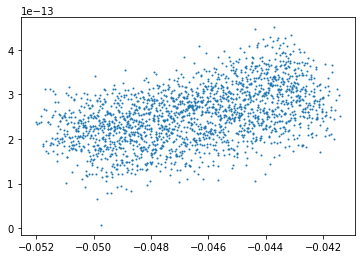

In [12]:
Uf = rfft2(SV.U)
W = vorticity2D(Uf,SV)
S = streamfunction(Uf,SV)

x = np.arange(514,554,dtype=int)
y = np.arange(488,538,dtype=int)
X,Y = np.meshgrid(x,y,indexing='ij')

W_val = W[X,Y]
S_val = S[X,Y]
plt.scatter(S_val,W_val,s=1)
plt.show()

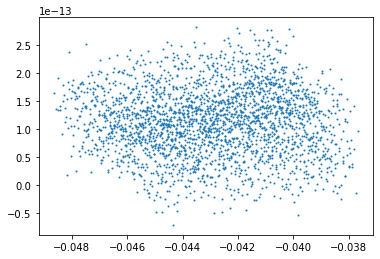

In [13]:
Uf = rfft2(SV.U)
W = vorticity2D(Uf,SV)
S = streamfunction(Uf,SV)

x = np.arange(454,504,dtype=int)
y = np.arange(488,538,dtype=int)
X,Y = np.meshgrid(x,y,indexing='ij')


W_val = W[X,Y]
S_val = S[X,Y]
plt.scatter(S_val,W_val,s=1)
plt.show()

## Lamb Oseen Rankine comparsion

In [24]:
# filepath = r"ouputs/Aug25/full_data/data_Re_3142_Ran_L12_1024.pkl"
# infile = open(filepath,'rb')
# SV_ran  = pickle.load(infile)
# CBV_ran  = pickle.load(infile)
# infile.close()

# filepath = r"ouputs/Aug25/full_data/data_Re_3142_LO_L12_1024.pkl"
filepath = r"ouputs/Aug25/full_data/data_rc_0.2_LO_st_nd_L12_1024_re_2400.pkl"
infile = open(filepath,'rb')
SV_LO  = pickle.load(infile)
CBV_LO  = pickle.load(infile)
infile.close()

In [4]:
# 4X4 plot
index = [0,1,4,9,16]
vort_ran = []
a_ran = []
a = np.sqrt(CBV_ran.vortex_pair_rad[0,0,1:]**2 + CBV_ran.vortex_pair_rad[1,0,1:]**2)
for i in index:
    U_ran = SV_ran.Ut[:,:,:,i]
    Uf = rfft2(U_ran)
    Xc,XCind = vortexPairCenterVortCentroid(Uf,SV_ran)
    W_ran = vorticity2D(Uf,SV_ran)
    vort_ran.append(W_ran[:,int(XCind[1,0])])
    if i!=16:
        a_ran.append(a[i*500])
    else:
        a_ran.append(a[i*500-1])


index = [0,1,4,9,16]
vort_LO = []
a_LO = []
a = np.sqrt(CBV_LO.vortex_pair_rad[0,0,1:]**2 + CBV_LO.vortex_pair_rad[1,0,1:]**2)
for i in index:
    U_LO = SV_LO.Ut[:,:,:,i]
    Uf = rfft2(U_LO)
    Xc,XCind = vortexPairCenterVortCentroid(Uf,SV_LO)
    W_LO = vorticity2D(Uf,SV_LO)
    vort_LO.append(W_LO[:,int(XCind[1,0])])
    if i!=16:
        a_LO.append(a[i*500])
    else:
        a_LO.append(a[i*500-1])

# data = {"vort_500":}
# savemat(filepath,)


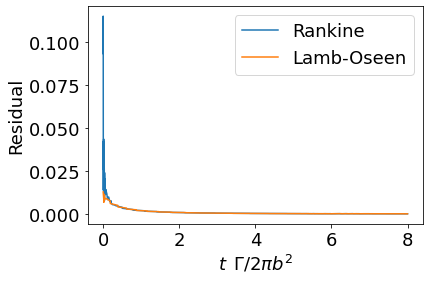

In [112]:
t = np.arange(0,SV_LO.T,SV_LO.dt)
plt.plot(t,CBV_ran.max_val_residual[1,1:])
plt.plot(t,CBV_LO.max_val_residual[1,1:])
plt.legend(['Rankine','Lamb-Oseen'])
plt.xlabel('$t \hspace{0.5}\Gamma/2\pi b^2$')
plt.ylabel('Residual')

plt.savefig("ouputs/Aug25/plots/LO_Ran_residue.png", facecolor='none', bbox_inches="tight",
            pad_inches=0.05, transparent=True, dpi=300)

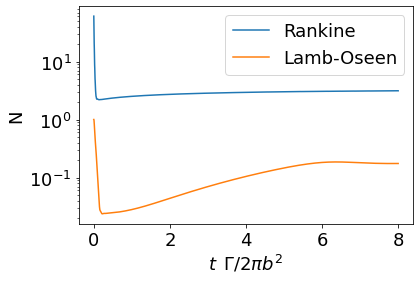

In [102]:
N = 8000
plt.semilogy(time[:N],CBV_ran.eulerResidual[1,:N])
plt.semilogy(time[:N],CBV_LO.eulerResidual[1,:N])

plt.xlabel('$t \hspace{0.5}\Gamma/2\pi b^2$')
plt.ylabel('N')
plt.legend(['Rankine','Lamb-Oseen'])
plt.savefig("ouputs/Aug25/plots/LO_Ran_Euler_residue.png", facecolor='none', bbox_inches="tight",
            pad_inches=0.05, transparent=True, dpi=300)

F:\Anaconda3\anaconda\envs\numcomp\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


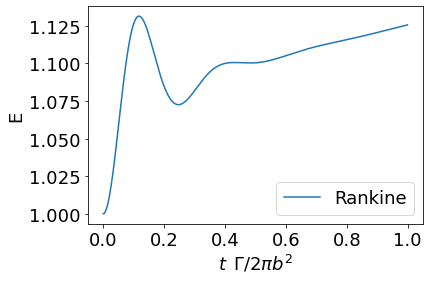

In [26]:
plt.rcParams['font.size'] = '18'   
N = 1000
t = np.arange(0,SV_LO.T,SV_LO.dt)

# ax = CBV_ran.vortex_pair_rad[0,1]
# ay = CBV_ran.vortex_pair_rad[1,1]
# E = ay/ax
# plt.plot(time[:N],E[:N],'--')

ax = CBV_LO.vortex_pair_rad[0,1]
ay = CBV_LO.vortex_pair_rad[1,1]
E = ay/ax
plt.plot(t[:N],E[:N])

plt.xlabel('$t \hspace{0.5}\Gamma/2\pi b^2$')
plt.ylabel('E')
plt.legend(['Rankine','Lamb-Oseen'])


# plt.savefig("ouputs/Aug25/plots/LO_Ran_E_small_time.png", facecolor='none', bbox_inches="tight",
#             pad_inches=0.05, transparent=True, dpi=300)

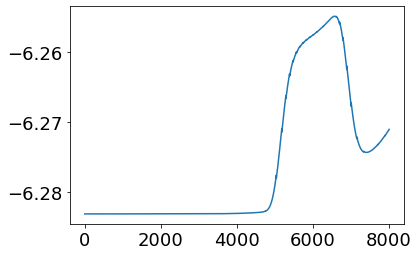

In [120]:
plt.plot(CBV_LO.gamma)

In [33]:
Ut = np.copy(SV.U)
Uf = rfft2(Ut)
Xc,XCind = vortexPairCenterVortCentroid(Uf,SV)
W_d = vorticity2D_fd(Ut,SV)
vort_ran[0] = W_d[:,int(XCind[1,0])]

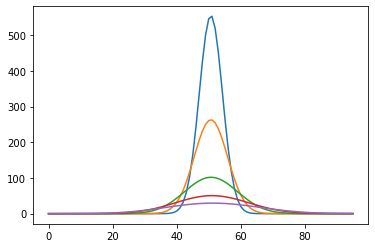

In [36]:
for i in range(5) : plt.plot(vort_LO[i][504:600])
plt.show()

In [102]:
from scipy.io import savemat
folderpath = r"ouputs/Aug25/mat_data/vorticity/"

filepath = folderpath + "vort_ran.mat"
data = {"vort_ran":vort_ran,"rad_a_ran":a_ran}
savemat(filepath,data)

filepath = folderpath + "vort_LO.mat"
data = {"vort_LO":vort_LO,"rad_a_LO":a_LO}
savemat(filepath,data)


## Lamb Oseen a/b = 0.2 study

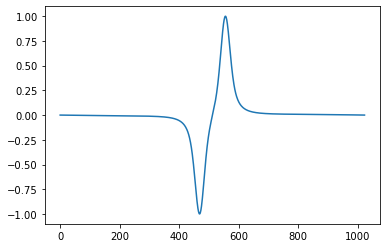

In [203]:
U = np.copy(SV.U)
Uf = rfft2(U)
Xc,XCind = vortexPairCenterVortCentroid(Uf,SV)
W = vorticity2D(Uf,SV)

strain_alt = velGradient(Uf,SV_LO)

folderpath = r"ouputs/Aug25/mat_data/full_data/"

filepath = folderpath + "vort_LO_rc_0.2_analytical.mat"
data = {"vort_alt":W,"U_alt":U,"vort_pos_alt":XCind,"strain_alt":strain_alt}
savemat(filepath,data)

SV.Mesh[0,1,512]
plt.plot(U[0,:,512])



In [248]:
filepath = r"ouputs/Aug25/full_data/data_rc_0.2_Re_3142_LO_L12_1024.pkl"
infile = open(filepath,'rb')
SV_LO  = pickle.load(infile)
CBV_LO  = pickle.load(infile)
infile.close()


In [311]:
Nt = -1
# Ut = SV.Ut[:,:,:,Nt]
U = SV_LO.Ut[:,:,:,-1] 
Uf = rfft2(U)
Xc,XCind = vortexPairCenterVortCentroid(Uf,SV_LO)
W = vorticity2D(Uf,SV_LO)
W[:,int(XCind[1,0])]
strain_sim = velGradient(Uf,SV_LO)

# folderpath = r"ouputs/Aug25/mat_data/full_data/"

# filepath = folderpath + "vort_LO_rc_0.2_sim.mat"
# data = {"vort_sim":W,"U_sim":U,"vort_pos_sim":XCind,"strain_sim":strain_sim}


# savemat(filepath,data)

Xc

array([[5.49810995, 6.5017916 ],
       [6.04432062, 6.04431564]])

In [321]:
# plt.plot(U[0,:,516-1])
%matplotlib widget
N = 1024
# x = np.linspace(0,12,N)
# y = np.ones(x.shape)*6.0443156
y = np.linspace(0,12,N)
x = np.ones(x.shape)*6.5017916
U_int = np.zeros(x.shape)
U_alt_int = np.zeros(x.shape)

for i in range(N):
    U_int[i]     = interpolate(x[i],y[i],U[1],SV_LO)
    U_alt_int[i] = interpolate(x[i],y[i],U_alt[1],SV)
    
    
plt.rcParams['font.size'] = '16'    
plt.plot(SV.Mesh[0,300:700,1],U_int[300+4:700+4])
plt.plot(SV.Mesh[0,300:700,1],U_alt_int[300:700])
plt.xlabel('$y/b$',fontsize=18)
plt.ylabel('$v$ velocity',fontsize=18,**{'fontname':'Helvetica'})
plt.legend(['Simulated','Analytical'])
# plt.hlines(0,0,12)
# plt.show()
plt.savefig("ouputs/Aug25/plots/LO_sim_alt_ay_vvel.png", facecolor='none', bbox_inches="tight",
            pad_inches=0.05, transparent=True, dpi=300)


SV.Mesh[0,469,1]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

5.49609375

In [377]:
# plt.plot(U[0,:,516-1])
%matplotlib widget
N = 1024
# x = np.linspace(0,12,N)
# y = np.ones(x.shape)*6.0443156
# y2 = np.ones(x.shape)*6.0
y = np.linspace(0,12,N)
y2 = y
x = np.ones(x.shape)*6.5017916
x2 = np.ones(x.shape)*6.5002051

U = SV_LO.Ut[:,:,:,-1] 
Uf = rfft2(U)
W_sim = vorticity2D(Uf,SV_LO)

U_alt = np.copy(SV.U)
Uf = rfft2(U_alt)
W_alt = vorticity2D(Uf,SV)

W_int = np.zeros(x.shape)
W_alt_int = np.zeros(x.shape)

for i in range(N):
    W_int[i]     = interpolate(x[i],y[i], W_sim,SV_LO)
    W_alt_int[i] = interpolate(x2[i],y2[i],W_alt,SV)
    
    
plt.rcParams['font.size'] = '16'    
plt.plot(SV.Mesh[1,1,400:624],    W_int[400+4:624+4])
plt.plot(SV.Mesh[1,1,400:624],W_alt_int[400:624])
plt.xlabel('$y/b$',fontsize=18)
plt.ylabel('vorticity',fontsize=18,**{'fontname':'Helvetica'})
plt.legend(['Simulated','Analytical'])
# plt.hlines(0,0,12)
# plt.show()
# plt.savefig("ouputs/Aug25/plots/LO_sim_alt_ay_vort.png", facecolor='none', bbox_inches="tight",
#             pad_inches=0.05, transparent=True, dpi=300)




Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [384]:
# x = np.linspace(0,12,N)
# y = np.ones(x.shape)*6.0443156
# y2 = np.ones(x.shape)*6.0
y = np.linspace(0,12,N)
y2 = y
x = np.ones(x.shape)*6.5017916
x2 = np.ones(x.shape)*6.5002051

U = SV_LO.Ut[:,:,:,-1] 
Uf = rfft2(U)
strain_sim = velGradient(Uf,SV_LO)

U_alt = np.copy(SV.U)
Uf = rfft2(U_alt)
strain_alt = velGradient(Uf,SV)

strain_sim_int = np.zeros((4,N))
strain_alt_int = np.zeros((4,N))

for i in range(N):
    strain_sim_int[0,i]  = interpolate(x[i],y[i], strain_sim[0],SV_LO)
    strain_sim_int[1,i]  = interpolate(x[i],y[i], strain_sim[1],SV_LO)
    strain_sim_int[2,i]  = interpolate(x[i],y[i], strain_sim[2],SV_LO)
    strain_sim_int[3,i]  = interpolate(x[i],y[i], strain_sim[3],SV_LO)
    
    strain_alt_int[0,i]  = interpolate(x2[i],y2[i], strain_alt[0],SV)
    strain_alt_int[1,i]  = interpolate(x2[i],y2[i], strain_alt[1],SV)
    strain_alt_int[2,i]  = interpolate(x2[i],y2[i], strain_alt[2],SV)
    strain_alt_int[3,i]  = interpolate(x2[i],y2[i], strain_alt[3],SV)


plt.rcParams['font.size'] = '12'   
fig = plt.figure()
gs = fig.add_gridspec(2,2)
axs = gs.subplots(sharex = True,sharey=True)
# fig.suptitle('Sharing both axes')
axs[0,0].plot(y[400:624],strain_sim_int[0][400+4:624+4],y2[400:624],strain_alt_int[0][400:624])
axs[0,0].set_ylabel('$du/dx$')
axs[0,1].plot(y[400:624],strain_sim_int[1][400+4:624+4],y2[400:624],strain_alt_int[1][400:624])
axs[0,1].set_ylabel('$du/dy$')
axs[1,0].plot(y[400:624],strain_sim_int[2][400+4:624+4],y2[400:624],strain_alt_int[2][400:624])
axs[1,0].set_ylabel('$dv/dx$')
axs[1,0].set_xlabel('$y/b$')
axs[1,1].plot(y[400:624],strain_sim_int[3][400+4:624+4],y2[400:624],strain_alt_int[3][400:624])
axs[1,1].set_ylabel('$dv/dy$')
axs[1,1].set_xlabel('$y/b$')
plt.legend(['Simulated','Analytical'])

plt.savefig("ouputs/Aug25/plots/LO_sim_alt_ay_strain.png", facecolor='none', bbox_inches="tight",
            pad_inches=0.05, transparent=True, dpi=300)


# Hide x labels and tick labels for all but bottom plot.
# for ax in axs.flat:
#     ax.label_outer()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [38]:
%matplotlib widget

L = 5
x = np.linspace(0,L,101)+1e-16 
xc = L/2

v = (x-xc)*(1-exp(-(x-xc)**2/0.04))/((x-xc)**2) # single vortex at the center of the domain
  + (x-xc-L)*(1-exp(-(x-xc-L)**2/0.04))/((x-xc-L)**2) +(x-xc+L)*(1-exp(-(x-xc+L)**2/0.04))/((x-xc+L)**2)\  # vortices at L = -2.5 and L = 7.5
  + (x-xc-2*L)*(1-exp(-(x-xc-2*L)**2/0.04))/((x-xc-2*L)**2)+(x-xc+2*L)*(1-exp(-(x-xc+2*L)**2/0.04))/((x-xc+2*L)**2) # vortices at L = -7.5 and L = 12.5

plt.rcParams['font.size'] = '12'   
plt.plot(x,v)
plt.hlines(0,0,5,'r',linestyle='--')
plt.xlabel("x")
plt.ylabel("tangential velocity")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [88]:
%matplotlib widget
from mpl_toolkits import mplot3d
xL,xR = 0,6
x = np.linspace(xL,xR,100)
y = x.copy()

X,Y = np.meshgrid(x,y,indexing='ij')

a = 1.05
n = 27
wx = 10**(-a**n*np.abs(2*(X-xL)/(xR-xL)-1)**n)
wy = 10**(-a**n*np.abs(2*(Y-xL)/(xR-xL)-1)**n)
w = wx*wy

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(X,Y,w)
# plt.plot(x,wy[1,:])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …